Tensor Network containing: 
Tensor with shape (2, 2) and indices ['QW0N1', 'QW0N0'] 
Tensor with shape (2, 2) and indices ['QW1N1', 'QW1N0'] 
Tensor with shape (2, 2) and indices ['QW2N1', 'QW2N0'] 
Tensor with shape (2, 2) and indices ['QW3N1', 'QW3N0'] 
Tensor with shape (2, 2, 2, 2) and indices ['QW0N2', 'QW1N2', 'QW0N1', 'QW1N1'] 
Tensor with shape (2, 2) and indices ['QW2N2', 'QW2N1'] 
Tensor with shape (2, 2) and indices ['QW3N2', 'QW3N1'] 
Tensor with shape (2, 2, 2, 2) and indices ['QW1N2', 'QW2N2', 'QW1N1', 'QW2N1'] 
Tensor with shape (2, 2) and indices ['QW0N2', 'QW0N1'] 
Tensor with shape (2, 2) and indices ['QW3N2', 'QW3N1'] 
Tensor with shape (2, 2, 2, 2) and indices ['QW2N2', 'QW3N2', 'QW2N1', 'QW3N1'] 
Tensor with shape (2, 2) and indices ['QW0N2', 'QW0N1'] 
Tensor with shape (2, 2) and indices ['QW1N2', 'QW1N1'] 

0 ['QW0N1', 'QW0N0']
1 ['QW1N1', 'QW1N0']
2 ['QW2N1', 'QW2N0']
3 ['QW3N1', 'QW3N0']
4 ['QW0N2', 'QW1N2', 'QW0N1', 'QW1N1']
5 ['QW2N2', 'QW2N1']
6 ['QW3N2', 'Q

KeyError: 'QW0N1'

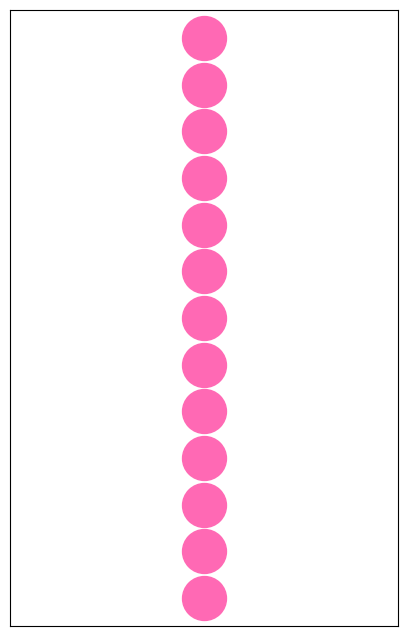

In [1]:
from tn4qa.mpo import MatrixProductOperator
from tn4qa.tn import TensorNetwork
from qiskit import QuantumCircuit

qc = QuantumCircuit(4)
qc.h(0)
qc.cx(0,1)
qc.cx(1,2)
qc.cx(2,3)

mpo = TensorNetwork.from_qiskit_circuit(qc)
print(mpo)
mpo.draw(1000, 5, 8)

In [1]:
import numpy as np
from pyblock2._pyscf.ao2mo import integrals as itg
from pyblock2.driver.core import DMRGDriver, SymmetryTypes

bond_dims = [250] * 4 + [500] * 4
noises = [1e-4] * 4 + [1e-5] * 4 + [0]
thrds = [1e-10] * 8

In [20]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SU2, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)
print(orb_sym)

[0, 5, 0, 5, 6, 7, 0, 2, 3, 5]


In [ ]:
mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)
print(dir(mpo.tensors[0]))
print(mpo.tensors[0])

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'copy', 'deallocate', 'deep_copy', 'get_total_memory', 'get_type', 'lmat', 'ops', 'reallocate', 'rmat']


TypeError: __getitem__(): incompatible function arguments. The following argument types are supported:
    1. (self: block2.su2.MapOpExprSpMat, arg0: block2.su2.OpExpr) -> block2.su2.SparseMatrix

Invoked with: MapOpExprSpMat{XL[ 0 12 ]: 0x12e98cc08, X[ 0 0 9 ]: 0x12e964ec8, X[ 0 0 1 ]: 0x12e98d028, XL[ 0 5 ]: 0x12e98d1c8, X[ 0 0 6 ]: 0x12e98cc08, XL[ 0 7 ]: 0x12e98d028, X[ 0 0 11 ]: 0x12e98d508, X[ 0 0 0 ]: 0x12e964f68, XL[ 0 9 ]: 0x12e98d428, X[ 0 0 4 ]: 0x12e98d348, X[ 0 0 13 ]: 0x12e98da78, X[ 0 0 5 ]: 0x12e98d428, X[ 0 0 10 ]: 0x12e98d1c8, XL[ 0 3 ]: 0x12e964ec8, XL[ 0 0 ]: 0x12e9644c8, XL[ 0 11 ]: 0x12e98d348, XL[ 0 2 ]: 0x10ce926f8, XL[ 0 1 ]: 0x12e98d508, I: 0x12e9644c8, XL[ 0 6 ]: 0x12e964f68, X[ 0 0 7 ]: 0x12e98d628, XL[ 0 4 ]: 0x12e98d628}, 0

In [21]:
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy)

pdm1 = driver.get_1pdm(ket)
pdm2 = driver.get_2pdm(ket).transpose(0, 3, 1, 2)
print('Energy from pdms = %20.15f' % (np.einsum('ij,ij->', pdm1, h1e)
    + 0.5 * np.einsum('ijkl,ijkl->', pdm2, driver.unpack_g2e(g2e)) + ecore))

impo = driver.get_identity_mpo()
expt = driver.expectation(ket, mpo, ket) / driver.expectation(ket, impo, ket)
print('Energy from expectation = %20.15f' % expt)


Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.093 | E =    -107.6541224475 | DW = 1.87294e-10

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.143 | E =    -107.6541224475 | DE = -5.23e-12 | DW = 6.78418e-20

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.202 | E =    -107.6541224475 | DE = 0.00e+00 | DW = 1.87284e-10

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.252 | E =    -107.6541224475 | DE = -8.81e-13 | DW = 8.89978e-20

Sweep =    4 | Direction =  forward | Bond dimension =  500 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      0.317 | E =    -107.6541224475 | DE = 2.84e-14 | DW = 1.06327e-19

Sweep =    5 | Direction = backward | 

In [1]:
import os
from pyscf import ao2mo, gto, scf
from cached_property import cached_property
import numpy as np
from openfermion import InteractionOperator, FermionOperator, geometry_from_pubchem, count_qubits
from openfermion.ops.representations import get_active_space_integrals
from openfermion.transforms.opconversions.jordan_wigner import _jordan_wigner_interaction_op
from openfermion.transforms.opconversions.bravyi_kitaev import _bravyi_kitaev_interaction_operator
from typing import Optional 
from pathlib import Path 
from qiskit.quantum_info.operators import SparsePauliOp, Pauli

def array_to_dict_nonzero_indices(arr, tol=1e-10):
    where_nonzero = np.where(~np.isclose(arr, 0, atol=tol))
    nonzero_indices = list(zip(*where_nonzero))
    return dict(zip(nonzero_indices, arr[where_nonzero]))

class MolecularIntegrals:
    def __init__(self, scf_obj, index_ordering='physicist') -> None:
        self.scf_obj = scf_obj
        self.c_matrix = scf_obj.mo_coeff
        self.n_spatial_orbs = scf_obj.mol.nao
        self.index_ordering = index_ordering
        self.n_spin_orbs = self.n_qubits = 2 * self.n_spatial_orbs
        self.n_electrons = scf_obj.mol.nelectron
        self.fermionic_molecular_hamiltonian=None
        self.qubit_molecular_hamiltonian=None

        
    @cached_property
    def _one_body_integrals(self):
        one_body_integrals = (
            self.c_matrix.T @ self.scf_obj.get_hcore() @ self.c_matrix
        )
        return one_body_integrals
    
    @cached_property
    def _two_body_integrals(self):
        two_body_integrals = ao2mo.restore(1, 
            ao2mo.kernel(self.scf_obj.mol,self.scf_obj.mo_coeff),
            self.scf_obj.mo_coeff.shape[1]
        )
        if self.index_ordering == 'physicist':
            # mapping to physicists' notations from PySCF chemists'
            # p, q, r, s -> p^ r^ s q, e.g. ⟨01|23⟩ ==> ⟨02|31⟩
            two_body_integrals = two_body_integrals.transpose(0,2,3,1)
        return two_body_integrals
    
    @cached_property
    def core_h_spin_basis(self):
        h_core_mo_basis_spin = np.zeros([self.n_spin_orbs]*2)
        h_core_mo_basis_spin[ ::2, ::2] = self._one_body_integrals
        h_core_mo_basis_spin[1::2,1::2] = self._one_body_integrals
        return h_core_mo_basis_spin
    
    @cached_property
    def eri_spin_basis(self):
        # alpha/beta electron indexing for chemists' and physicists' notation
        if self.index_ordering == 'chemist':
            a,b,c,d=(0,0,1,1)
            e,f,g,h=(1,1,0,0)
        elif self.index_ordering == 'physicist':
            a,b,c,d=(0,1,1,0)
            e,f,g,h=(1,0,0,1)
            
        eri_mo_basis_spin = np.zeros([self.n_spin_orbs]*4)
        # same spin (even *or* odd indices)
        eri_mo_basis_spin[ ::2, ::2, ::2, ::2] = self._two_body_integrals
        eri_mo_basis_spin[1::2,1::2,1::2,1::2] = self._two_body_integrals
        # different spin (even *and* odd indices)
        eri_mo_basis_spin[a::2,b::2,c::2,d::2] = self._two_body_integrals
        eri_mo_basis_spin[e::2,f::2,g::2,h::2] = self._two_body_integrals
        return eri_mo_basis_spin

    def get_active_space_spin_ints(self, occupied_indices, active_indices):

        ### get active space in SPATIAL setting
        core_const_shift, one_body_spatial_ints, two_body_spatial_ints = get_active_space_integrals(self._one_body_integrals,
                                                                                        self._two_body_integrals,
                                                                                        occupied_indices=occupied_indices,
                                                                                     active_indices=active_indices)

        ### convert active space spatial integrals to SPIN ints!
        n_spin_orbs = 2* len(active_indices)
        h_core_mo_basis_spin = np.zeros([n_spin_orbs]* 2)
        h_core_mo_basis_spin[::2, ::2] = one_body_spatial_ints
        h_core_mo_basis_spin[1::2, 1::2] = one_body_spatial_ints

        if self.index_ordering == 'chemist':
            a, b, c, d = (0, 0, 1, 1)
            e, f, g, h = (1, 1, 0, 0)
        elif self.index_ordering == 'physicist':
            a, b, c, d = (0, 1, 1, 0)
            e, f, g, h = (1, 0, 0, 1)

        eri_mo_basis_spin = np.zeros([n_spin_orbs] * 4)
        # same spin (even *or* odd indices)
        eri_mo_basis_spin[::2, ::2, ::2, ::2] = two_body_spatial_ints
        eri_mo_basis_spin[1::2, 1::2, 1::2, 1::2] = two_body_spatial_ints
        # different spin (even *and* odd indices)
        eri_mo_basis_spin[a::2, b::2, c::2, d::2] = two_body_spatial_ints
        eri_mo_basis_spin[e::2, f::2, g::2, h::2] = two_body_spatial_ints

        return core_const_shift, h_core_mo_basis_spin, eri_mo_basis_spin
    
def get_hamiltonian(scf_obj=None,
        constant_shift=0, hcore=None, eri=None, 
        operator_type='qubit', qubit_transformation='JW'
    ):
    if scf_obj is not None:
        integral_storage = MolecularIntegrals(scf_obj)
        constant_shift = scf_obj.energy_nuc()
        hcore = integral_storage.core_h_spin_basis
        eri = integral_storage.eri_spin_basis
        n_qubits = integral_storage.n_qubits
    else:
        assert (
            hcore is not None and
            eri is not None
        ), 'Must supply molecular integrals'
        n_qubits = eri.shape[0]

    if operator_type == 'qubit':
        interaction_operator = InteractionOperator(
            constant = constant_shift, 
            one_body_tensor = hcore, 
            two_body_tensor = eri*.5
        )
        if qubit_transformation in ['JW', 'jordan_wigner']:
            qubit_op = _jordan_wigner_interaction_op(interaction_operator, n_qubits=n_qubits)
        elif qubit_transformation in ['BK', 'bravyi_kitaev']:
            qubit_op = _bravyi_kitaev_interaction_operator(interaction_operator, n_qubits=n_qubits)
        else:
            raise ValueError('Unrecognised qubit transformation')
        return qubit_op
    
    elif operator_type == 'fermion':
        one_body_coefficients = array_to_dict_nonzero_indices(hcore)
        two_body_coefficients = array_to_dict_nonzero_indices(eri)

        fermionic_molecular_hamiltonian = FermionOperator('', constant_shift)
        for (p,q), coeff in one_body_coefficients.items():
            fermionic_molecular_hamiltonian += FermionOperator(f'{p}^ {q}', coeff)
        for (p,q,r,s), coeff in two_body_coefficients.items():
            fermionic_molecular_hamiltonian += FermionOperator(f'{p}^ {q}^ {r} {s}', coeff*.5)
        return fermionic_molecular_hamiltonian

In [2]:
mol = gto.M(atom="N 0 0 0; N 0 0 1.1", basis="sto3g", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ham = get_hamiltonian(mf)

In [3]:
def qubitop_to_pauliop(ham):
    n_qubits = count_qubits(ham)
    qubit_operator = ham
    paulis = []
    coeffs = []

    for qubit_terms, coefficient in qubit_operator.terms.items():
        pauli_label = ['I' for _ in range(n_qubits)]
        coeff = coefficient
        
        for tensor_term in qubit_terms:
            pauli_label[tensor_term[0]] = tensor_term[1]
        
        pauli_label = ''.join(pauli_label)
                    
        paulis.append(Pauli(pauli_label))
        coeffs.append(coeff)
    
    pauliOp = SparsePauliOp(paulis, coeffs=coeffs)
    
    return pauliOp

ham2 = qubitop_to_pauliop(ham)
# print(len(ham2))
ham_dict = {str(ham2[i].paulis[0]) : ham2[i].coeffs[0].real for i in range(len(ham2))}
import json 
with open("test/hams/N2_ham.json", "w") as f:
    json.dump(ham_dict, f)
    

In [29]:
from dataclasses import dataclass
from enum import Enum
import sparse

class PauliTerm(Enum):
    I = "I"
    X = "X"
    Y = "Y"
    Z = "Z"

@dataclass(frozen=True)
class UpdateValues:
    indices: tuple[int, int, int, int]
    weights: tuple[complex, complex]

def _update_array(
    array: list,
    data: list,
    weight: complex,
    p_string_idx: int,
    term: str,
    offset: bool = False,
) -> None:
    match term:
        case PauliTerm.I.value:
            update_values = UpdateValues((0, 0, 1, 1), (1, 1))
        case PauliTerm.X.value:
            update_values = UpdateValues((0, 1, 1, 0), (1, 1))
        case PauliTerm.Y.value:
            update_values = UpdateValues((0, 1, 1, 0), (-1j, 1j))
        case PauliTerm.Z.value:
            update_values = UpdateValues((0, 0, 1, 1), (1, -1))

    for i in [0, 1]:
        array[0].append(p_string_idx)
        if offset:
            array[1].append(p_string_idx)

        array[1 + int(offset)].append(update_values.indices[2 * i])
        array[2 + int(offset)].append(update_values.indices[(2 * i) + 1])
        data.append(update_values.weights[i] * weight)

def hamiltonian_to_mpo(ham_dict) -> MatrixProductOperator:
    # num_qubits: int = count_qubits(hamiltonian)

    # ham_dict = {}
    # term_dict = hamiltonian.terms
    # for key in hamiltonian.terms.keys():
    #     letters = [
    #         key[i][1] if i in key else PauliTerm.I.value for i in range(num_qubits)
    #     ]
    #     p_string = "".join(letters)
    #     ham_dict[p_string] = term_dict[key]

    num_qubits = len(list(ham_dict.keys())[0])
    num_ham_terms = len(ham_dict.keys())

    first_array_coords: list[list[int]] = [[], [], []]
    middle_array_coords: list[list[list[int]]] = [
        [[], [], [], []] for _ in range(1, num_qubits - 1)
    ]
    last_array_coords: list[list[int]] = [[], [], []]
    first_array_data: list[complex] = []
    middle_array_data: list[list[complex]] = [[] for _ in range(1, num_qubits - 1)]
    last_array_data: list[complex] = []

    for p_string_idx, (p_string, weight) in enumerate(ham_dict.items()):
        # p_string = p_string[::-1]

        # First Term
        _update_array(
            first_array_coords, first_array_data, weight, p_string_idx, p_string[0]
        )

        # Middle Terms
        for p_idx in range(1, num_qubits - 1):
            p = p_string[p_idx]
            _update_array(
                middle_array_coords[p_idx - 1],
                middle_array_data[p_idx - 1],
                1,
                p_string_idx,
                p,
                offset=True,
            )

        # Final Term
        _update_array(last_array_coords, last_array_data, 1, p_string_idx, p_string[-1])

    first_array = sparse.COO(
        first_array_coords, first_array_data, shape=(num_ham_terms, 2, 2)
    )
    middle_arrays = [
        sparse.COO(
            middle_array_coords[i - 1],
            middle_array_data[i - 1],
            shape=(num_ham_terms, num_ham_terms, 2, 2),
        )
        for i in range(1, num_qubits - 1)
    ]
    last_array = sparse.COO(
        last_array_coords, last_array_data, shape=(num_ham_terms, 2, 2)
    )

    return MatrixProductOperator.from_arrays([first_array] + middle_arrays + [last_array])

In [53]:
from typing import Tuple 
from tn4qa.mps import MatrixProductState
from tn4qa.mpo import MatrixProductOperator
from tn4qa.tensor import Tensor
from tn4qa.tn import TensorNetwork
from pyblock2.driver.core import DMRGDriver, SymmetryTypes
from pyblock2._pyscf.ao2mo import integrals as itg
import psutil
import block2
from pyscf import scf
from scipy.sparse.linalg import eigs 
import sparse
import copy

class FermionDMRG:

    def __init__(self,
                 scf_obj : scf,
                 HF_symmetry : str,
                 max_mpo_bond : int,
                 max_mps_bond : int,
                 n_core : int=0,
                 n_cas : int=None,
                 g2e_symm : int=1
                 ) -> "FermionDMRG":
        """
        Constructor for the FermionDMRG class. A simple wrapper around Block2 functionality.
        
        Args:
            scf_obj: The (post-HF) scf object.
            HF_symmetry: One of "RHF" or "UHF".
            max_mpo_bond: The maximum bond dimension to use for MPO construction.
            max_mps_bond: The maximum bond dimension to use for MPS during DMRG.
            n_core (optional): The number of core electrons (default 0).
            ncas (optional): The number of electrons in the CAS (default None=all).
            g2e_symm (optional): Symmetry group for 2-electron integrals (default 1).
            
        Returns:
            The FermionDMRG object.
        """
        self.scf_object = scf_obj
        self.HF_symmetry = HF_symmetry
        if self.HF_symmetry == "RHF":
            self.symm_type = SymmetryTypes.SU2
            self.ncas, self.n_elec, self.spin, self.ecore, self.h1e, self.g2e, self.orb_sym = itg.get_rhf_integrals(scf_obj, ncore=n_core, ncas=n_cas, g2e_symm=g2e_symm)
        elif self.HF_symmetry == "UHF":
            self.symm_type = SymmetryTypes.SZ
            self.ncas, self.n_elec, self.spin, self.ecore, self.h1e, self.g2e, self.orb_sym = itg.get_uhf_integrals(scf_obj, ncore=n_core, ncas=n_cas, g2e_symm=g2e_symm)
        else:
            raise ValueError("Unsupported HF symmetry type.")
        self.max_mpo_bond = max_mpo_bond
        self.max_mps_bond = max_mps_bond

        self.driver = self.initialise_driver()

        return
    
    def initialise_driver(self) -> DMRGDriver:
        """
        Initialise the DMRG driver.

        Returns:
            The DMRG driver
        """ 
        n_threads = int(psutil.cpu_count() / psutil.cpu_count(False))
        driver = DMRGDriver(scratch="./tmp", symm_type=self.symm_type, n_threads=n_threads)
        driver.initialize_system(n_sites=self.ncas, n_elec=self.n_elec, spin=self.spin, orb_sym=self.orb_sym)

        return driver
    
    def set_initial_state(self) -> block2:
        """
        Set the initial state for DMRG.
        """
        block2_mps = self.driver.get_random_mps(tag="GS", bond_dim=self.max_mps_bond, nroots=1)

        return block2_mps
    
    def set_hamiltonian(self) -> block2:
        """
        Set the Hamiltonian for DMRG.
        """
        mpo = self.driver.get_qc_mpo(h1e=self.h1e, g2e=self.g2e, ecore=self.ecore, iprint=0)

        return mpo

    def run(self, maxiter : int) -> float:
        """
        Find the groundstate energy of an MPO with DMRG.
        
        Args:
            maxiter: The maximum number of DMRG sweeps.
        
        Returns:
            The DMRG energy.
        """
        mpo = self.set_hamiltonian()
        mps = self.set_initial_state()
        driver = self.driver
        bond_dims = [int(self.max_mps_bond/2)] * 4 + [self.max_mps_bond] * 4
        noises = [1e-4] * 4 + [1e-5] * 4 + [0]
        thrds = [1e-10] * 8
        energy = driver.dmrg(mpo, mps, n_sweeps=maxiter, bond_dims=bond_dims, noises=noises,thrds=thrds, iprint=0)

        return energy
class QubitDMRG:

    def __init__(self, 
                 hamiltonian : dict[str, complex],
                 max_mpo_bond : int,
                 max_mps_bond : int
                 ) -> "QubitDMRG":
        """
        Constructor for the QubitDMRG class.
        
        Args:
            hamiltonian: A dict of the form {pauli_string : weight}.
            max_mpo_bond: The maximum bond to use for the Hamiltonian MPO construction.
            max_mps_bond: The maximum bond to use for MPS during DMRG.
        
        Returns:
            The QubitDMRG object.
        """
        self.hamiltonian = hamiltonian
        self.num_sites = len(list(hamiltonian.keys())[0])
        self.max_mpo_bond = max_mpo_bond
        self.max_mps_bond = max_mps_bond
        self.mps = self.set_initial_state()
        self.mpo = self.set_hamiltonian_mpo()

        return
    
    def set_initial_state(self, mps : MatrixProductState=None) -> MatrixProductState:
        """
        Set the initial state for DMRG.
        
        Args:
            mps (optional): An optional input state. Defaults to random.
        """
        if not mps:
            mps = MatrixProductState.random_quantum_state_mps(self.num_sites, self.max_mps_bond)

        mps = self.add_trivial_tensors_mps(mps)

        return mps
    
    def set_hamiltonian_mpo(self) -> MatrixProductOperator:
        """
        Convert the Hamiltonian to an MPO for DMRG.
        """
        # mpo = MatrixProductOperator.from_hamiltonian(self.hamiltonian, self.max_mpo_bond)
        mpo = hamiltonian_to_mpo(self.hamiltonian)
        # if mpo.bond_dimension > self.max_mpo_bond:
        #     mpo.compress(self.max_mpo_bond)

        mpo = self.add_trivial_tensors_mpo(mpo)

        return mpo
    
    def add_trivial_tensors_mps(self, mps : MatrixProductState) -> MatrixProductState:
        """
        Add trivial tensors to MPS.
        """ 
        mps.tensors[0].data = sparse.reshape(mps.tensors[0].data, (1,)+mps.tensors[0].dimensions)
        mps.tensors[-1].data = sparse.reshape(mps.tensors[-1].data, (mps.tensors[-1].dimensions[0], 1, mps.tensors[-1].dimensions[1]))

        trivial_array = sparse.COO.from_numpy(np.array([1,1], dtype=complex).reshape(1,2))
        all_arrays = [trivial_array] + [mps.tensors[i].data for i in range(self.num_sites)] + [trivial_array]
        mps = MatrixProductState.from_arrays(all_arrays)
        return mps
    
    def add_trivial_tensors_mpo(self, mpo : MatrixProductOperator) -> MatrixProductOperator:
        """
        Add trivial tensors to MPO.
        """
        mpo.tensors[0].data = sparse.reshape(mpo.tensors[0].data, (1,)+mpo.tensors[0].dimensions)
        mpo.tensors[-1].data = sparse.reshape(mpo.tensors[-1].data, (mpo.tensors[-1].dimensions[0], 1, mpo.tensors[-1].dimensions[1], mpo.tensors[-1].dimensions[2]))
        
        trivial_array = sparse.COO.from_numpy(np.array([[1,1],[1,1]], dtype=complex).reshape(1,2,2))
        all_arrays = [trivial_array] + [mpo.tensors[i].data for i in range(self.num_sites)] + [trivial_array]
        mpo = MatrixProductOperator.from_arrays(all_arrays)
        return mpo
    
    def remove_trivial_tensors_mps(self, mps : MatrixProductState) -> MatrixProductState:
        """
        Remove trivial tensors from MPS.
        """
        first_array = sparse.reshape(mps.tensors[1].data, (mps.tensors[1].dimensions[1], mps.tensors[1].dimensions[2]))
        middle_arrays = [mps.tensors[i].data for i in range(2, self.num_sites-1)]
        last_array = sparse.reshape(mps.tensors[-2].data, (mps.tensors[-2].dimensions[0], mps.tensors[-2].dimensions[2]))
        mps = MatrixProductState.from_arrays([first_array] + middle_arrays + [last_array])
        return mps
    
    def remove_trivial_tensors_mpo(self, mpo : MatrixProductOperator) -> MatrixProductOperator:
        """
        Remove trivial tensors from MPS.
        """ 
        first_array = sparse.reshape(mpo.tensors[1].data, (mpo.tensors[1].dimensions[1], mpo.tensors[1].dimensions[2], mpo.tensors[1].dimensions[3]))
        middle_arrays = [mpo.tensors[i].data for i in range(2, self.num_sites-1)]
        last_array = sparse.reshape(mpo.tensors[-2].data, (mpo.tensors[-2].dimensions[0], mpo.tensors[-2].dimensions[2], mpo.tensors[-2].dimensions[3]))
        mpo = MatrixProductOperator.from_arrays([first_array] + middle_arrays + [last_array])
        return mpo
    
    def construct_expectation_value_tn(self) -> TensorNetwork:
        """
        Construct <mps | mpo | mps>.
        """
        mps = copy.deepcopy(self.mps)
        mps_dag = copy.deepcopy(self.mps)
        mps_dag.dagger()
        mpo = copy.deepcopy(self.mpo)

        num_sites = len(mps.tensors)

        mps.tensors[0].indices = ["b1", "p1"]
        mps_dag.tensors[0].indices = ["bdag1", "pdag1"]
        mpo.tensors[0].indices = ["hb1", "p1", "pdag1"]

        for idx in range(1, num_sites-1):
            mps.tensors[idx].indices = [f"b{idx}", f"b{idx+1}", f"p{idx+1}"]
            mps_dag.tensors[idx].indices = [f"bdag{idx}", f"bdag{idx+1}", f"pdag{idx+1}"]
            mpo.tensors[idx].indices = [f"hb{idx}", f"hb{idx+1}", f"p{idx+1}", f"pdag{idx+1}"]

        mps.tensors[-1].indices = [f"b{num_sites-1}", f"p{num_sites}"]
        mps_dag.tensors[-1].indices = [f"bdag{num_sites-1}", f"pdag{num_sites}"]
        mpo.tensors[-1].indices = [f"hb{num_sites-1}", f"p{num_sites}", f"pdag{num_sites}"]

        all_tensors = mps.tensors + mps_dag.tensors + mpo.tensors 
        tn = TensorNetwork(all_tensors)
        return tn
    
    def get_environment_tensor(self, site_idx : int) -> Tensor:
        """
        Return the environment matrix of the Hamiltonian at given site.
        
        Args:
            site_idx: The site index.
        
        Returns:
            A Tensor object with indices [udag, pdag, ddag, u, p, d]
        """
        tn = self.construct_expectation_value_tn()
        tn.pop_tensors_by_label([f"MPS_T{site_idx}"])
        env_tensor = tn.contract_entire_network()
        env_tensor.reorder_indices([f"bdag{site_idx-1}", f"pdag{site_idx}", f"bdag{site_idx}", f"b{site_idx-1}", f"p{site_idx}", f"b{site_idx}"])
        env_tensor.indices = ["udag", "pdag", "ddag", "u", "p", "d"]

        return env_tensor
    
    def sweep(self, direction : str) -> float:
        """
        Perform one DMRG sweep.
        
        Args:
            direction: Either "F" (forward) or "B" (backward)

        Return:
            The current groundstate energy estimate.
        """
        sites = list(range(2, self.num_sites+2))
        if direction == "B": sites = sites[::-1]

        for site in sites:
            env_tensor = self.get_environment_tensor(site)
            env_tensor.tensor_to_matrix(["u", "p", "d"], ["udag", "pdag", "ddag"])
            w, v = eigs(env_tensor.data, k=1, which="SR")
            eigval = w[0]
            eigvec = sparse.COO.from_numpy(v[:, 0]) # This is the new optimal value at site i
            if site == 2:
                new_data = sparse.reshape(eigvec, (1, 2, self.max_mps_bond))
            elif site == self.num_sites+1:
                new_data = sparse.reshape(eigvec, (self.max_mps_bond, 2, 1))
            else:
                new_data = sparse.reshape(eigvec, (self.max_mps_bond, 2, self.max_mps_bond))
            new_data = sparse.moveaxis(new_data, [0,1,2], [0,2,1])

            original_indices = self.mps.tensors[site-1].indices
            original_labels = self.mps.tensors[site-1].labels
            self.mps.pop_tensors_by_label(original_labels)
            new_t = Tensor(new_data, original_indices, original_labels)
            self.mps.add_tensor(new_t, site-1)
        
        return eigval

    def run(self, maxiter : int) -> Tuple[float, MatrixProductState]:
        """
        Find the groundstate of an MPO with DMRG.
        
        Args:
            max_mps_bond: The maximum bond dimension allowed. 
            maxiter: The maximum number of DMRG sweeps.
        
        Returns:
            A tuple of the DMRG energy and the DMRG state.
        """
        for _ in range(maxiter):
            e = self.sweep("F")
            e = self.sweep("B")
        
        energy = e.real / 16 # Trivial end tensors mean we overcount the energy by factor of 2*4*2
        # self.mps = self.remove_trivial_tensors_mps(self.mps)
        # self.mpo = self.remove_trivial_tensors_mpo(self.mpo)

        # tn = self.construct_expectation_value_tn()
        # energy = tn.contract_entire_network().real

        return (energy, self.mps)

In [54]:
import json
import os 
cwd = os.getcwd()
location = os.path.join(cwd, "test/hams/N2_ham.json")
with open(location, "r") as f:
    ham = json.load(f)
dmrg = QubitDMRG(ham, np.infty, 4)

In [55]:
energy, _ = dmrg.run(2)
print(energy)

-107.01610716639871


In [19]:
import quimb.tensor as qtn

def ham_to_mpo(ham):
        num_qubits = count_qubits(ham)

        ham_dict = {}
        term_dict = ham.terms
        terms = list(term_dict.keys())
        for t in terms:
            letters = ['I' for _ in range(num_qubits)]
            for i in t:
                letters[i[0]] = i[1]
            p_string = ''.join(letters)
            ham_dict[p_string] = term_dict[t]

        num_ham_terms = len(list(ham_dict.keys()))

        first_array_coords = [[],[],[]]
        middle_array_coords = [[[],[],[],[]] for _ in range(1, num_qubits-1)]
        last_array_coords = [[],[],[]]
        first_array_data = []
        middle_array_data = [[] for _ in range(1, num_qubits-1)]
        last_array_data = []

        for p_string_idx in range(num_ham_terms):
            p_string = list(ham_dict.keys())[p_string_idx][::-1]
            weight = ham_dict[p_string[::-1]]

            first_term = p_string[0]
            if first_term == "I":
                first_array_coords[0].append(p_string_idx)
                first_array_coords[1].append(0)
                first_array_coords[2].append(0)
                first_array_data.append(weight)

                first_array_coords[0].append(p_string_idx)
                first_array_coords[1].append(1)
                first_array_coords[2].append(1)
                first_array_data.append(weight)

            elif first_term == "X":
                first_array_coords[0].append(p_string_idx)
                first_array_coords[1].append(0)
                first_array_coords[2].append(1)
                first_array_data.append(weight)

                first_array_coords[0].append(p_string_idx)
                first_array_coords[1].append(1)
                first_array_coords[2].append(0)
                first_array_data.append(weight)

            elif first_term == "Y":
                first_array_coords[0].append(p_string_idx)
                first_array_coords[1].append(0)
                first_array_coords[2].append(1)
                first_array_data.append(-1j*weight)

                first_array_coords[0].append(p_string_idx)
                first_array_coords[1].append(1)
                first_array_coords[2].append(0)
                first_array_data.append(1j*weight)

            else:
                first_array_coords[0].append(p_string_idx)
                first_array_coords[1].append(0)
                first_array_coords[2].append(0)
                first_array_data.append(weight)

                first_array_coords[0].append(p_string_idx)
                first_array_coords[1].append(1)
                first_array_coords[2].append(1)
                first_array_data.append(-1*weight)
            
            for p_idx in range(1, num_qubits-1):
                p = p_string[p_idx]
                if p == "I":
                    middle_array_coords[p_idx-1][0].append(p_string_idx)
                    middle_array_coords[p_idx-1][1].append(p_string_idx)
                    middle_array_coords[p_idx-1][2].append(0)
                    middle_array_coords[p_idx-1][3].append(0)
                    middle_array_data[p_idx-1].append(1)

                    middle_array_coords[p_idx-1][0].append(p_string_idx)
                    middle_array_coords[p_idx-1][1].append(p_string_idx)
                    middle_array_coords[p_idx-1][2].append(1)
                    middle_array_coords[p_idx-1][3].append(1)
                    middle_array_data[p_idx-1].append(1)

                elif p == "X":
                    middle_array_coords[p_idx-1][0].append(p_string_idx)
                    middle_array_coords[p_idx-1][1].append(p_string_idx)
                    middle_array_coords[p_idx-1][2].append(0)
                    middle_array_coords[p_idx-1][3].append(1)
                    middle_array_data[p_idx-1].append(1)

                    middle_array_coords[p_idx-1][0].append(p_string_idx)
                    middle_array_coords[p_idx-1][1].append(p_string_idx)
                    middle_array_coords[p_idx-1][2].append(1)
                    middle_array_coords[p_idx-1][3].append(0)
                    middle_array_data[p_idx-1].append(1)

                elif p == "Y":
                    middle_array_coords[p_idx-1][0].append(p_string_idx)
                    middle_array_coords[p_idx-1][1].append(p_string_idx)
                    middle_array_coords[p_idx-1][2].append(0)
                    middle_array_coords[p_idx-1][3].append(1)
                    middle_array_data[p_idx-1].append(-1j)

                    middle_array_coords[p_idx-1][0].append(p_string_idx)
                    middle_array_coords[p_idx-1][1].append(p_string_idx)
                    middle_array_coords[p_idx-1][2].append(1)
                    middle_array_coords[p_idx-1][3].append(0)
                    middle_array_data[p_idx-1].append(1j)

                else:
                    middle_array_coords[p_idx-1][0].append(p_string_idx)
                    middle_array_coords[p_idx-1][1].append(p_string_idx)
                    middle_array_coords[p_idx-1][2].append(0)
                    middle_array_coords[p_idx-1][3].append(0)
                    middle_array_data[p_idx-1].append(1)

                    middle_array_coords[p_idx-1][0].append(p_string_idx)
                    middle_array_coords[p_idx-1][1].append(p_string_idx)
                    middle_array_coords[p_idx-1][2].append(1)
                    middle_array_coords[p_idx-1][3].append(1)
                    middle_array_data[p_idx-1].append(-1)

            final_term = p_string[-1]
            if final_term == "I":
                last_array_coords[0].append(p_string_idx)
                last_array_coords[1].append(0)
                last_array_coords[2].append(0)
                last_array_data.append(1)

                last_array_coords[0].append(p_string_idx)
                last_array_coords[1].append(1)
                last_array_coords[2].append(1)
                last_array_data.append(1)

            elif final_term == "X":
                last_array_coords[0].append(p_string_idx)
                last_array_coords[1].append(0)
                last_array_coords[2].append(1)
                last_array_data.append(1)

                last_array_coords[0].append(p_string_idx)
                last_array_coords[1].append(1)
                last_array_coords[2].append(0)
                last_array_data.append(1)

            elif final_term == "Y":
                last_array_coords[0].append(p_string_idx)
                last_array_coords[1].append(0)
                last_array_coords[2].append(1)
                last_array_data.append(-1j)

                last_array_coords[0].append(p_string_idx)
                last_array_coords[1].append(1)
                last_array_coords[2].append(0)
                last_array_data.append(1j)

            else:
                last_array_coords[0].append(p_string_idx)
                last_array_coords[1].append(0)
                last_array_coords[2].append(0)
                last_array_data.append(1)

                last_array_coords[0].append(p_string_idx)
                last_array_coords[1].append(1)
                last_array_coords[2].append(1)
                last_array_data.append(-1)

        first_array = sparse.COO(first_array_coords, first_array_data, shape=(num_ham_terms, 2, 2))
        middle_arrays = [sparse.COO(middle_array_coords[i-1], middle_array_data[i-1], shape=(num_ham_terms, num_ham_terms, 2, 2)) for i in range(1, num_qubits-1)]
        last_array = sparse.COO(last_array_coords, last_array_data, shape=(num_ham_terms,2,2))

        ham_mpo = qtn.MatrixProductOperator([first_array]+middle_arrays+[last_array])
        return ham_mpo

def get_dmrg_solution(ham, max_bond):
    ham_mpo = ham_to_mpo(ham)
    mydmrg = qtn.DMRG2(ham_mpo, bond_dims=[max_bond], cutoffs=1e-10)
    mydmrg.solve(tol=1e-6, verbosity=0)
    return mydmrg.state, mydmrg.energy

In [20]:
sol, e = get_dmrg_solution(ham, 8)
print(e)

-107.05677251991854
